<a href="https://colab.research.google.com/github/nissi00/machine-learning/blob/main/connectionkaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Préparation de l'environnement

[Apprendre à utilider une api kaggle](https://youtu.be/up8R4jT49Ak)



In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle/

In [ ]:
! cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d pushpalama/grape-disease

100% 151M/151M [00:08<00:00, 23.8MB/s]
100% 151M/151M [00:08<00:00, 19.7MB/s]


In [ ]:
! unzip /content/grape-disease.zip -d maladie_de_raisin

In [ ]:
data= "/content/maladie_de_raisin/grape_dataset/train"
test = "/content/maladie_de_raisin/grape_dataset/test"

In [ ]:
!ls

drive  grape-disease.zip  maladie_de_raisin  sample_data


In [ ]:
#Importatation des différentes bibliothèques
from keras.layers.preprocessing import image_preprocessing
from tensorflow.python import platform
import tensorflow as tf
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Model
from keras.layers import preprocessing
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow_hub as hub
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime, os
import cv2

# Péparation des données

In [ ]:
#la redimensionn ainsi que la fixation de la taille des images
datagen = ImageDataGenerator(rescale=1./255)
img_size = 224
#la variable batch c'est pour dire que notre modèle reccevra 32 images à chaque epoch pour l'entrainement
batch = 32

In [ ]:
# ici j'ai juste creer les differentes variables pour importer les images
# de keras preprocessing.image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)
vali_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=123,

    interpolation="bilinear",

)




Found 7222 files belonging to 4 classes.
Using 5778 files for training.
Found 7222 files belonging to 4 classes.
Using 1444 files for validation.
Found 1805 files belonging to 4 classes.


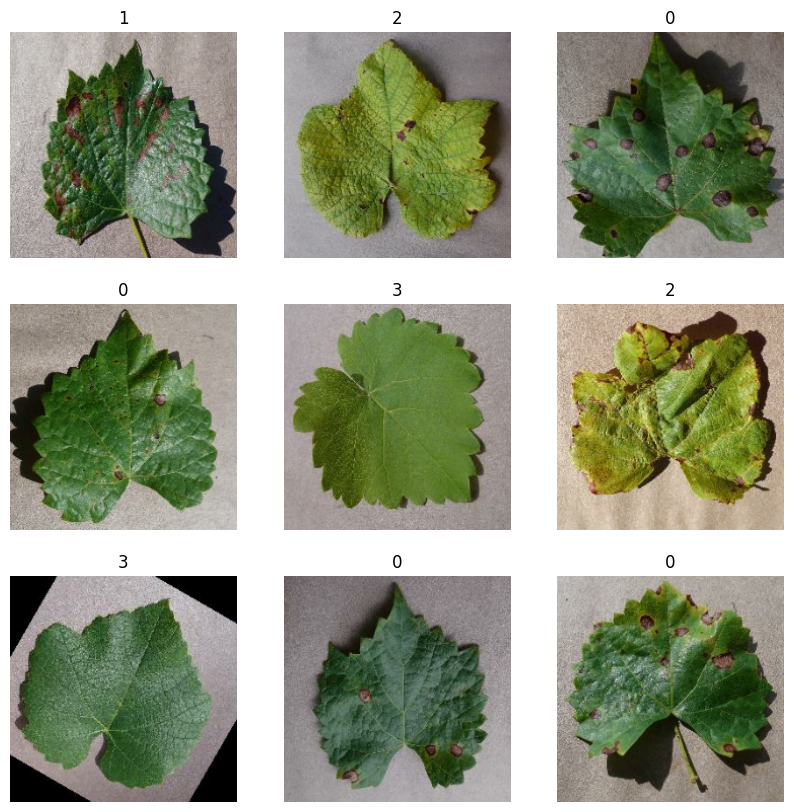

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


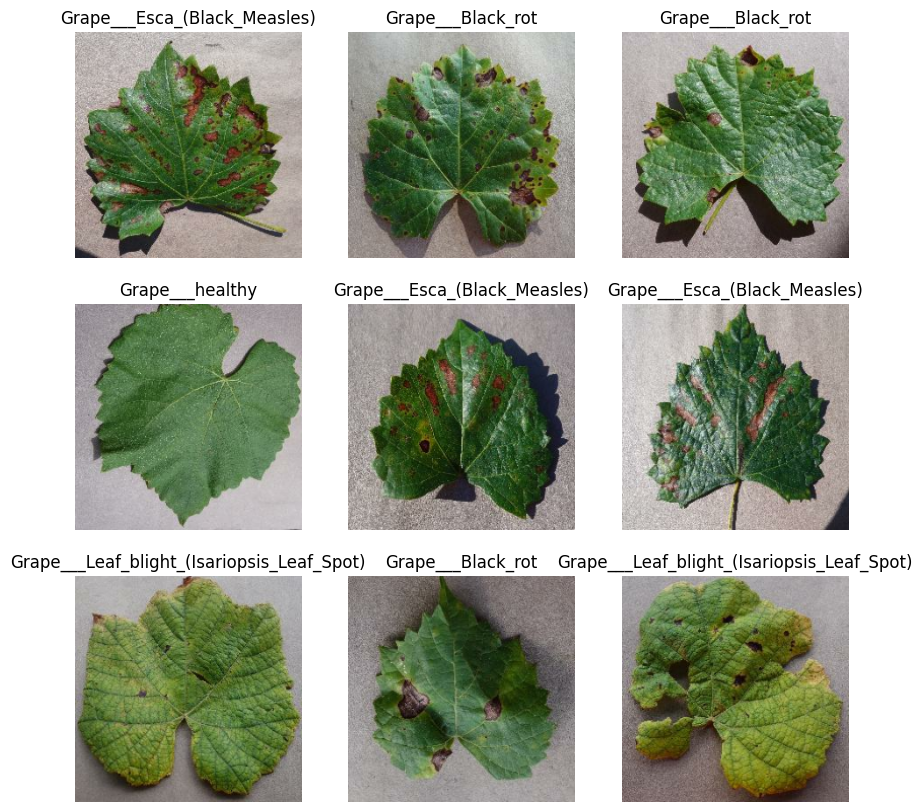

In [ ]:
import matplotlib.pyplot as plt

# Créer un dictionnaire qui mappe les étiquettes numériques aux noms des plantes
label_names = ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy'] # Remplacez ceci par les noms réels de vos plantes
label_dict = {i: name for i, name in enumerate(label_names)}

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = label_dict[int(labels[i])] # Obtenir le nom de plante correspondant à l'étiquette numérique
        plt.title(label)
        plt.axis("off")


La formation d'un réseau de neurones nécessite une quantité énorme de données. Pour anticiper une évantuelle insuffisance de données nous allons générer des images pour alimenter notre cnn.
Cette génération d'images consiste à mettre les images de notre dataset dans différentes positions et formes( renversé, inversé, compressé , avec une variation du contraste, verticale, horizontale,diagonale). 

In [ ]:

# keras imageDataGenerator
train_data = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    vertical_flip=True,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
)

vali_data = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    vertical_flip=True,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [ ]:
# Pour chaque partie de notre set (train et val) nous allons 
# nous allons lui lier l'ensemble généré correspondant 
train_generator = train_data.flow_from_directory(
    data,
    batch_size = batch,
    class_mode = 'sparse',
    target_size = (img_size,img_size),
    shuffle = True,
    subset = 'training'
)

vali_generator = train_data.flow_from_directory(
    data,
    batch_size = batch,
    class_mode = 'sparse',
    target_size = (img_size,img_size),
    shuffle = True,
    subset = 'validation'
)

Found 5779 images belonging to 4 classes.
Found 1443 images belonging to 4 classes.


In [ ]:
#juste afficher mes differents labels
class_names = train_ds.class_names
print(class_names)
train_name = test_ds.class_names
print(train_name)

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']
['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']


# Pré-traitement des données

In [ ]:
import os
liste= ["/content/maladie_de_raisin/grape_dataset/train","/content/maladie_de_raisin/grape_dataset/test"]
num_skipped = 0

for folder_name in ('Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy'):
        folder_path = os.path.join("/content/maladie_de_raisin/grape_dataset/test", folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
               num_skipped += 1
            # Delete corrupted image
               os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
#Normalisation des données
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notez que les valeurs de pixel sont maintenant dans `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.91288596


In [ ]:
# juste augmente le nombre des élements du dataset
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_size,img_size,3)),
   layers.RandomContrast(factor=0.2)
  ]
)

In [ ]:
x_train, y_train = next(train_generator)
x_test, y_test = next(vali_generator)

# Constuction du modèle

12683000/12683000 [==============================] - 2s 0us/step


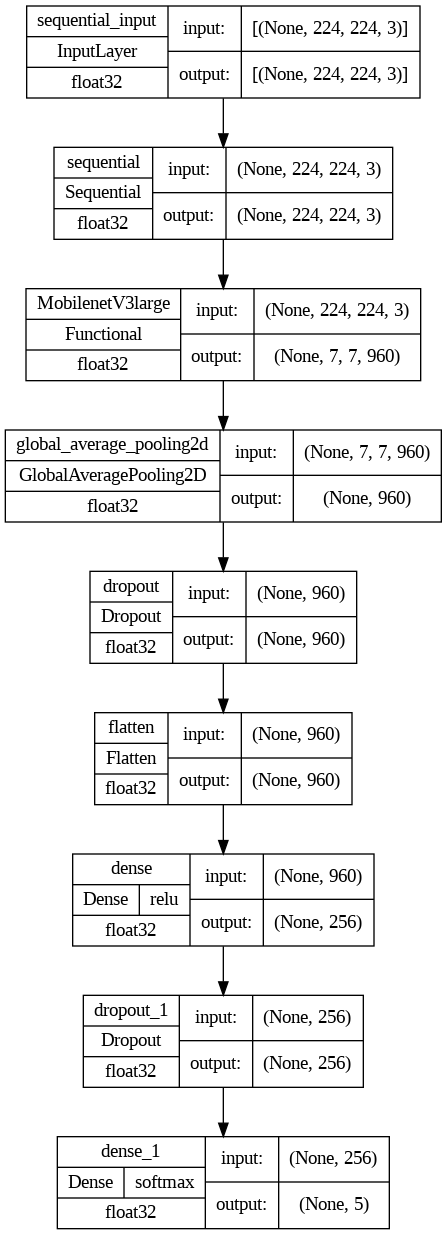

In [ ]:
#Construction et architecture du modèle
from keras.applications.mobilenet_v3 import MobileNetV3Large
model_base = MobileNetV3Large(include_top = False, weights = 'imagenet',
                             input_shape = (img_size, img_size, 3))

fine_tune_at = 200

model_base.trainable = False

model2 = tf.keras.models.Sequential()
#model2.add(layers.Rescaling(1./255))
model2.add(data_augmentation)
model2.add(model_base)
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dropout(0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation = "relu"))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(5, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.6, mode='auto', min_lr = 1e-5)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/cassava6.h7", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max', period=1)
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tf.keras.utils.plot_model(
    model2,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 256)              

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
#Compilation et entrainement du modèle
model2.compile(optimizer=keras.optimizers.Adam(1e-5), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
#model2.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001,   decay=1e-6),loss="SparseCategoricalCrossentropy",metrics=["accuracy"])
history = model2.fit(train_ds,
                             epochs=100,
                             validation_data=vali_ds,
                              callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard_callback ])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Evaluer le modèle 

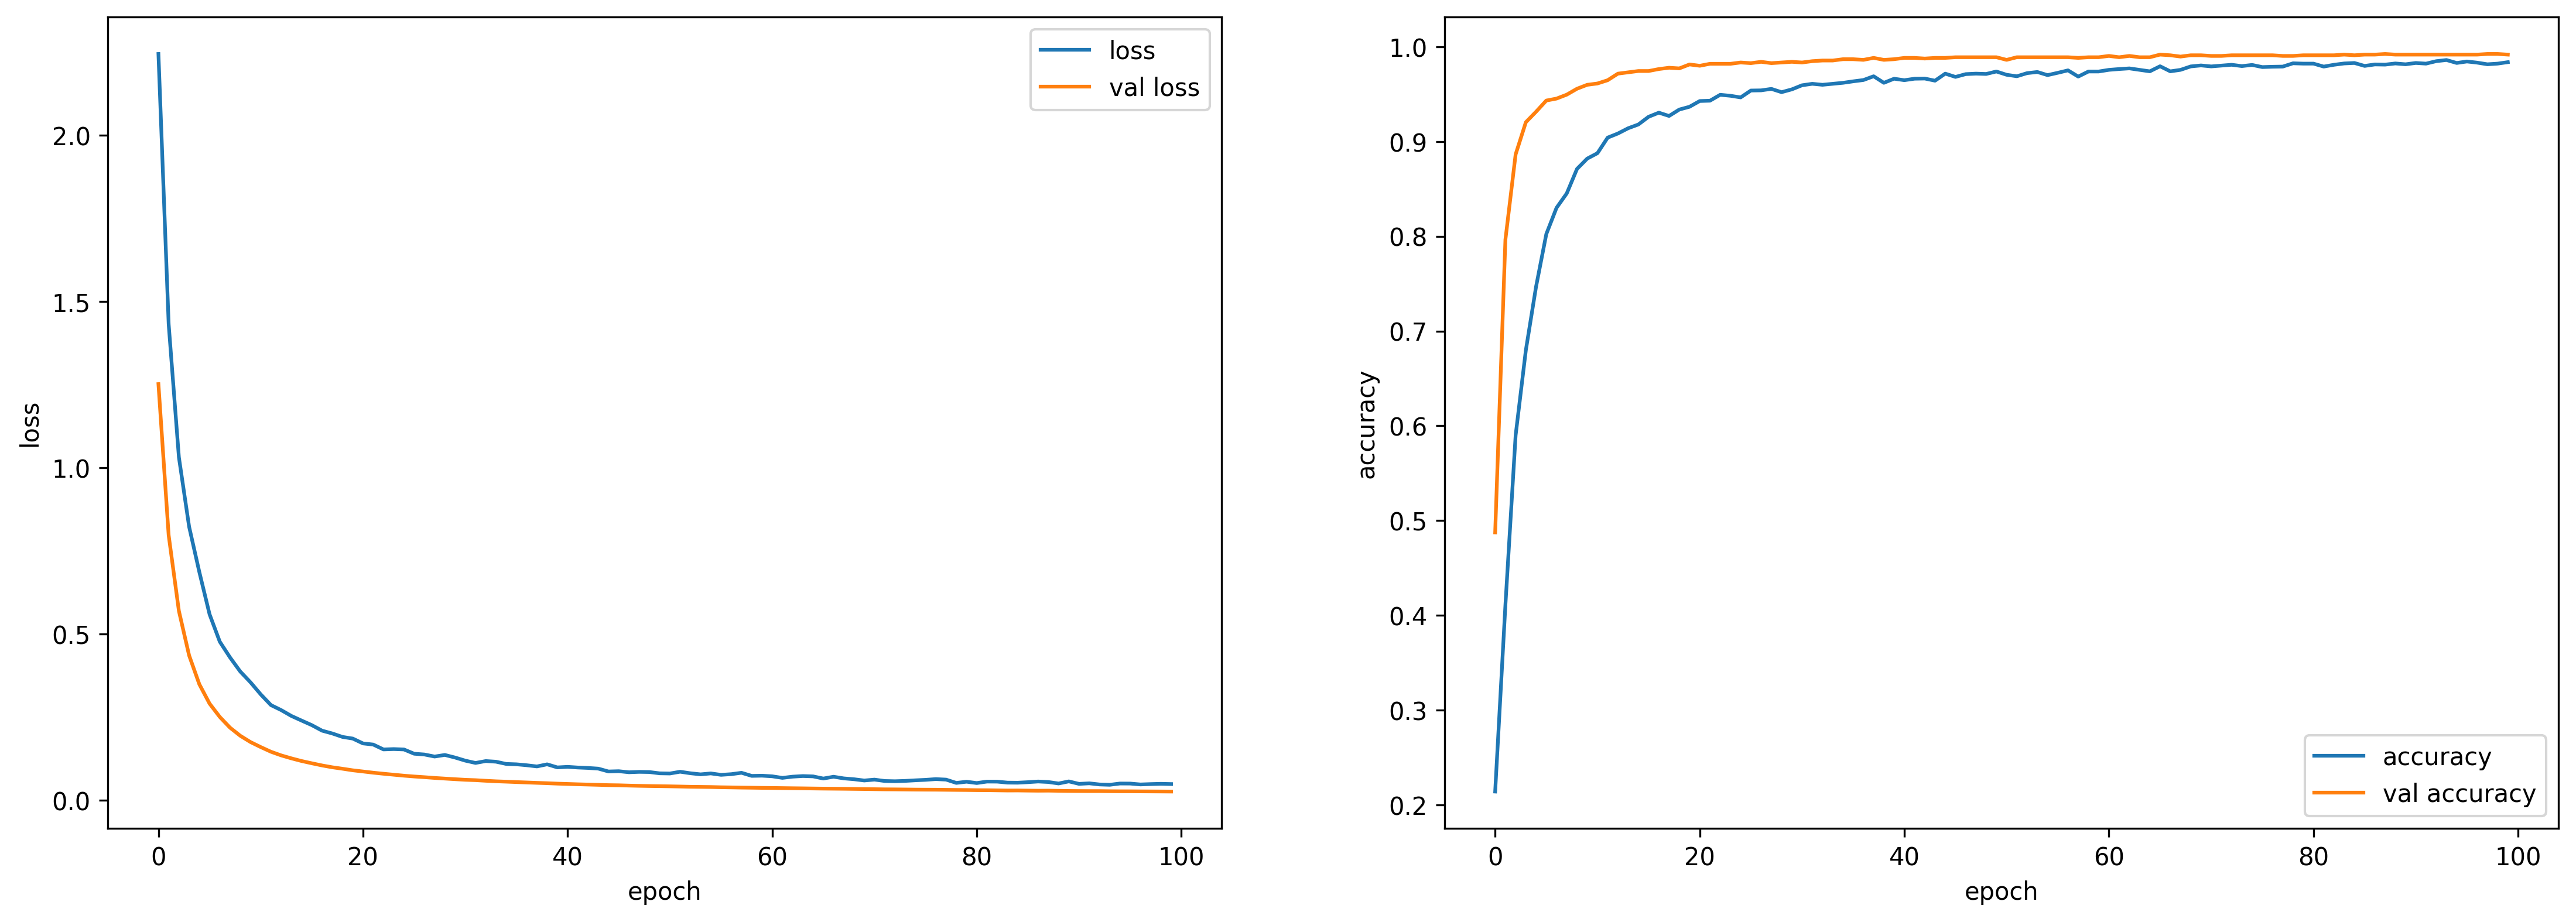

In [ ]:
#Tracer les courbes
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(history.history['loss'])))

sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')

plt.show()

In [ ]:
model2.save("/content/drive/MyDrive/kaggle/raisin.h5")

In [ ]:
loss, accuracy = model2.evaluate(x_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


1/1 [==============================] - 1s 1s/step - loss: 1.4967 - accuracy: 0.2812
Test loss: 1.4967310428619385
Test accuracy: 0.28125


# Teste 

Tester le modèle sur une image connu de la machine

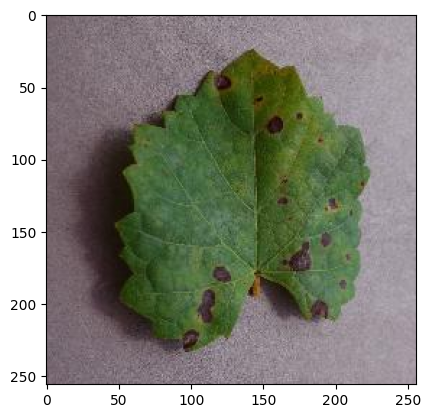

1/1 [==============================] - 0s 23ms/step
[0]
cbb


In [ ]:
#Tester le modèle sur une image

img_to_predict = cv2.imread("/content/maladie_de_raisin/grape_dataset/test/Grape___Black_rot/00090b0f-c140-4e77-8d20-d39f67b75fcc___FAM_B.Rot 0376.JPG", cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img_to_predict, cv2.COLOR_BGR2RGB))
plt.show()
image_to_predict = np.expand_dims(cv2.resize(img_to_predict,(224,224)), axis=0)
res = model2.predict(image_to_predict).argmax(axis=-1)
#y_classes = keras.np_utils.probas_to_classes(res)

print(res)
if res == 0:
  print('Grape___Black_rot')
elif res ==1:
  print('Grape___Esca_(Black_Measles')
elif res ==2:
  print('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)')
elif res ==3:
  print('Grape___healthy')


Tester le modèle sur une nouvelle image, une imagge totalement inconnue de la machine.

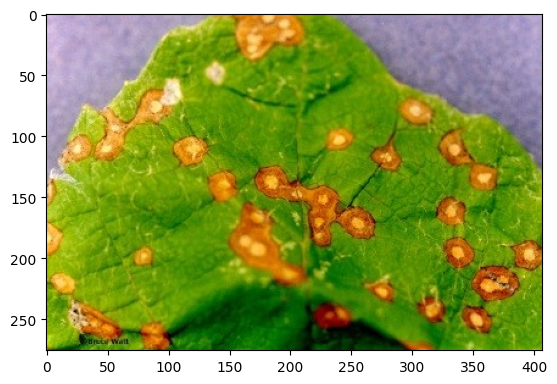

1/1 [==============================] - 0s 49ms/step
L'image est prédite comme étant : Grape___Black_rot
La précision de la prédiction est : 0.6145381


In [ ]:
# Créer un dictionnaire qui mappe les étiquettes prédites à des étiquettes de maladies correspondantes
label_dict = {0: 'Grape___Black_rot', 1: 'Grape___Esca_(Black_Measles)', 2: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 3: 'Grape___healthy'}

# Charger l'image à prédire
img_to_predict = cv2.imread("/content/Grape___Black_rot.jpg", cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img_to_predict, cv2.COLOR_BGR2RGB))
plt.show()

# Prétraiter l'image
image_to_predict = np.expand_dims(cv2.resize(img_to_predict,(224,224)), axis=0)

# Faire la prédiction
res = model2.predict(image_to_predict, verbose=1)

# Récupérer l'indice de l'étiquette prédite avec la plus haute probabilité
predicted_label_index = np.argmax(res)

# Utiliser le dictionnaire pour remplacer l'indice de l'étiquette prédite par une étiquette de maladie correspondante
predicted_label = label_dict[predicted_label_index]

# Afficher le résultat
print("L'image est prédite comme étant :", predicted_label)
print("La précision de la prédiction est :", res[0][predicted_label_index])
